## Example: American Option Pricing using the Longstaff-Schwartz Monte-Carlo Method 
The Longstaff and Schwartz Least Squares method (LSM) is a technique to estimate the premium of an American-style options contract. It involves simulating a risk-neutral geometric Brownian motion of the underlying share price to generate a range of possible future prices. Backward-induction is then used to estimate the premium of the options contract. 

During each time step, the LSM approach estimates a local regression model of the share price (X) versus the discounted payoff of the contract (Y) to approximate conditional expectation $\mathbb{E}(Y|X)$. This means that it predicts the expected future payoff given the current share price. A decision is then made based on the predicted payoff: 

* If the current payoff is greater than the expected future payoff computed from $\mathbb{E}(Y|X)$, the contract holder exercises the contract now.
* If the current payoff is less than the expected future payoff, the contract holder continues to hold the contract.

This calculation is performed for each path in the collection of sample paths computed by the geometric Brownian motion model. The final contract price is then calculated as the average over all the sample paths. The LSM method was introduced by Longstaff and Schwartz in their paper:


* [Longstaff, F.A.; Schwartz, E.S. (2001). "Valuing American options by simulation: a simple least squares approach". Review of Financial Studies. 14: 113–148. CiteSeerX 10.1.1.155.3462. doi:10.1093/rfs/14.1.113.](https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf)

### Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
Precompiling project...
  ✓ VLQuantitativeFinancePackage
  1 dependency successfully precompiled in 5 seconds. 251 already precompiled.
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Deskt

### Data
We downloaded the options chain for [Advanced Micro Devices (AMD)](https://en.wikipedia.org/wiki/AMD) from [barchart.com](https://www.barchart.com). For this set of values, the share price of `AMD` was $S_{\circ}$ = 117.50 USD/share, and the average implied volatility for `AMD` options with `DTE = 31 days` is `IV = 51.75%`. 

We load the options data using the `MyOptionsChainDataSet()` function and store in the `options_dataset` variable, which is an instance of `DataFrame`:

In [2]:
options_dataset = MyOptionsChainDataSet();

## Least-Squares Monte Carlo Method of Longstaff and Schwartz

Let's use this approach to simulate the premium of American-style `put` contracts as a function of the strike price `K`. 

* Let's set constant values for the `put` contracts (these values are the same for each strike price `K`). The time will be calendar days `Δt = 1/365`, the initial share price `Sₒ` is `117.50 USD/share`, the days to expiration or `DTE` is `31` days, the annual risk-free rate is `r̄ = 0.0418` and the (average) implied volatility `IV = 51.75%`.

In [3]:
Δt = (1.0/365.0);
Sₒ = 117.50;
DTE = 64.0*Δt;
r̄ = 0.0418;
IV = 0.5175;

We construct an instance of the `MyGeometricBrownianMotionEquityModel` type, which holds values associated with the underlying price simulation. We store this data in the `gbm_model` variable:

In [4]:
gbm_model = build(MyGeometricBrownianMotionEquityModel, (
    μ = r̄, σ = IV
));

We sample the geometric Brownian motion model (compute `number_of_paths` sample paths) using the `sample(...)` function. The sample paths are stored in the array `X`:

In [5]:
X = VLQuantitativeFinancePackage.sample(gbm_model, (
    T₁ = 0.0, T₂ = DTE, Δt = Δt, Sₒ = Sₒ
), number_of_paths = 20000);

In [6]:
X

65×20001 Matrix{Float64}:
 0.0         117.5    117.5     117.5     …  117.5     117.5    117.5
 0.00273973  122.785  118.501   116.943      113.585   117.56   114.46
 0.00547945  123.457  114.909   118.522      113.987   117.682  114.717
 0.00821918  123.463  109.769   114.308      114.649   119.485  116.237
 0.0109589   127.393  108.067   113.939      114.672   118.97   113.778
 0.0136986   130.397  106.44    110.678   …  106.022   120.61   114.667
 0.0164384   132.611  104.697   114.028      103.306   121.946  115.525
 0.0191781   135.68   102.593   114.63       103.309   119.45   114.602
 0.0219178   132.934  103.363   121.793      102.212   115.128  116.66
 0.0246575   133.562  103.947   114.432       99.2158  118.091  117.591
 0.0273973   135.543   99.9816  116.007   …   98.3775  111.479  118.73
 0.030137    133.362  104.951   112.41        95.8224  108.474  123.639
 0.0328767   137.508  108.627   114.538       97.0721  109.523  121.808
 ⋮                                        ⋱

We create an instance of the `MyLongstaffSchwartzContractPricingModel` type, which holds a modified sample paths array `Ŝ` 
* We remove the time column and the initial share price, and transpose the array so that the sample paths are on the rows, time is along the columns). We store the Longstaff model in the `longstaff_model` variable

In [7]:
X1 = X[:,2:end]
X2 = X1[2:end,:]
Ŝ = transpose(X2);
longstaff_model = build(MyLongstaffSchwartzContractPricingModel, (
    S = Ŝ, r̄ = r̄, Δt = Δt
));

We calculate the premium for various strike prices, ranging from `K=60` to `K=160`, and record the estimated premium in the `df_LSM_simulation` DataFrame. For each strike price:

* We first check if there is an existing `IV` value in the dataset. If there is, we use that `IV` value. Otherwise, we use the average value for the implied volatility, `IV = 0.5175`. 
* Then, we use the `build(…)` method to create an instance of the `MyAmericanCallContractModel` type, which contains information about the contract. This is stored in the `call_contract_model` variable. Finally, we calculate the premium for this contract using the `premium(…)` function.

In [8]:
start_strike = 60.0;
stop_strike = 160.0;
KA = range(start_strike, stop = stop_strike, step=1) |> collect;
dataset = filter([:Type, :Strike] => (x,y)-> x == "Put" && y ∈ KA, options_dataset);
df_LSM_simulation = DataFrame(K=Float64[], premium = Float64[])
for value ∈ KA
    
    # compute the IV - use average IV is not in dataset
    tmp = dataset[dataset.Strike .== value, :IV]
    IV_value = 0.5175;
    if (isempty(tmp) == false)
        IV_value = first(tmp);
    end

    # contract model -
    put_contract_model = build(MyAmericanPutContractModel, (
        K = value, IV = first(IV_value), DTE = DTE, sense = 1
    ));

    # call the longstaff code -
    price_value = premium(put_contract_model, longstaff_model)

    # store the results
    results_tuple = (
        K = value,
        premium = price_value
    );
    push!(df_LSM_simulation, results_tuple);
end

#### Visualize
Let's plot the strike price `K` on the horizontal axis and the estimated premium on the vertical axis. 
* The LSM option price simulation fails to capture the prices of `put` options that are `near the money`, i.e., when $S_{\circ}\simeq{K}$, but does capture the prices for `in the money`, i.e., $S_{\circ} \ll {K}$ and `out of the money`, i.e., $S_{\circ}\gg{K}$ `put` contracts:

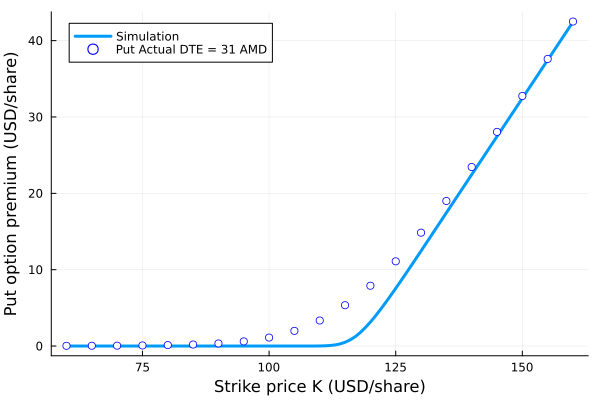

In [9]:
plot(df_LSM_simulation[:,1],df_LSM_simulation[:,2], lw=3, label="Simulation")
scatter!(dataset[:,:Strike], dataset[:,:Ask],label="Put Actual DTE = 31 AMD", mc=:white, msc=:blue)
xlabel!("Strike price K (USD/share)", fontsize=18)
ylabel!("Put option premium (USD/share)", fontsize=18) 